# Hello, _nbpresent_!

In [ ]:
import nbpresent
nbpresent.__version__

# DB2 Symposium 2017

# DB2 Security, Performance, and a Touch of Cloud

## Setting up this Jupyter Notebook

This notebook should be launched from a session of jupyter notebook that was launched from a DB2 command window
To do this, run an administrator DB2 command window as an administrator and type 'jupyter notebook'

Set up the enviornment:

In [ ]:
os.environ['DB2INSTANCE']

In [ ]:
import sys,os,os.path
os.environ['IBM_DB_HOME']='C:\Program Files\IBM\SQLLIB_01'
!pip install ipython-sql
!pip install ibm_db 
!pip install ibm_db_sa

Restart the Kernel if this is your first time installing the above. The next steps will fail unless you do this.

Import the modules and load the SQL magic

In [1]:
import sys,os,os.path
#os.environ['DB2INSTANCE']='DB2_01'
#os.environ['DB2PATH']='C:\Program Files\IBM\SQLLIB_01'
import ibm_db
import ibm_db_sa
import sqlalchemy
%load_ext sql

Connect to the database. Change the values of user, host, and password to match your environment. For connection to a local host, use 'localhost' for the host name. Also change the port number and database name in the connection string.

In [2]:
user='db2admin'
host='localhost'
password="""db2admin"""
%sql db2+ibm_db://$user:$password@$host:50001/SAMPLE

'Connected: db2admin@SAMPLE'

## SQL from this Presentation

### The Basics of DB2 Security

#### Listing Instance-Level Authority Groups

In [3]:
%sql SELECT NAME \
	, substr(VALUE,1,25) as value \
	, substr(DEFERRED_VALUE,1,25) as deferred FROM SYSIBMADM.DBMCFG \
WHERE NAME LIKE '%_group'

Done.


name,VALUE,deferred
sysadm_group,DB2ADMNS,DB2ADMNS
sysctrl_group,None,None
sysmaint_group,None,None
sysmon_group,DB2MON,DB2MON


#### Investigating Database-Level Authorities and Permissions
##### List IDs with Explicit CONNECT

In [4]:
%sql select grantee \
from syscat.dbauth \
where connectauth='Y'

Done.


grantee


##### List Specific Database Authorities and Permissions for a Specific User

In [5]:
check_id='ECROOKS'
%sql select dbadmauth \
	, connectauth \
	, dataaccessauth \
    , securityadmauth \
from syscat.dbauth \
where grantee='$check_id'

Done.


dbadmauth,connectauth,dataaccessauth,securityadmauth
Y,N,Y,Y


##### List Database Authorities and Permissions for All Users/Groups/Roles

In [6]:
%sql select grantee \
    , dbadmauth as dbadm \
    , connectauth as conn \
    , dataaccessauth as dataaccess \
    , bindaddauth as bindadd \
    , createtabauth as createtab \
    , externalroutineauth as extroutine \
    , implschemaauth as implschema \
    , loadauth as load \
    , nofenceauth as nofence \
    , quiesceconnectauth as quiesceconn \
    , securityadmauth as secadm \
    , wlmadmauth as wlmadm \
    , explainauth as explain \
    , accessctrlauth as accessctrl \
from syscat.dbauth 

Done.


grantee,dbadm,conn,dataaccess,bindadd,createtab,extroutine,implschema,load,nofence,quiesceconn,secadm,wlmadm,EXPLAIN,accessctrl
DB2ADMIN,Y,N,Y,N,N,N,N,N,N,N,Y,N,N,Y
PUBLIC,N,N,N,Y,Y,N,Y,N,N,N,N,N,N,N
ECROOKS,Y,N,Y,N,N,N,N,N,N,N,Y,N,N,Y
WCS_ADMIN,Y,N,Y,N,N,N,N,N,N,N,N,N,N,Y
DB2ADMIN,N,N,N,N,N,N,N,N,N,N,Y,N,N,N


#### Investigating Object-Level Permissions

##### List Certain Table Permissions for a Specific User

In [7]:
check_id='ECROOKS'
%sql select tabschema \
    , tabname \
    , controlauth \
    , deleteauth \
    , insertauth \
    , selectauth \
    , updateauth \
from syscat.tabauth \
where grantee='$check_id'

Done.


tabschema,tabname,controlauth,deleteauth,insertauth,selectauth,updateauth
ECROOKS,ACTIVITYMETRICS_ACT_STMT,Y,G,G,G,G
ECROOKS,ACTIVITYSTMT_ACT_STMT,Y,G,G,G,G
ECROOKS,ACTIVITYVALS_ACT_STMT,Y,G,G,G,G
ECROOKS,ACTIVITY_ACT_STMT,Y,G,G,G,G
ECROOKS,CONTROL_ACT_STMT,Y,G,G,G,G
ECROOKS,T1,Y,G,G,G,G
ECROOKS,T2,Y,G,G,G,G
SYSTOOLS,STMG_DBSIZE_INFO,Y,G,G,G,G


##### List Users and Certain Permissions for a Specific Table

In [8]:
check_tabschema='ECROOKS' 
check_tabname='SALES' 
%sql select grantee \
    , controlauth \
    , deleteauth \
    , insertauth \
    , selectauth \
    , updateauth \
from syscat.tabauth \
where tabschema='$check_tabschema' \
    and tabname='$check_tabname'

Done.


grantee,controlauth,deleteauth,insertauth,selectauth,updateauth


### Label-Based Access Control

#### Create Security Label Component

In [ ]:
%sql create security label component reg_sec_comp tree ('UNRESTRICTED' ROOT, \
'MANITOBA' under 'UNRESTRICTED', \
'ONTARIO' under 'UNRESTRICTED', \
'Quebec' under 'UNRESTRICTED')

#### Create Security Policy

In [ ]:
%sql create security policy sec_policy components reg_sec_comp with db2lbacrules

#### Create Security Labels

In [ ]:
%sql create security label sec_policy.manitoba component reg_sec_comp 'MANITOBA'
%sql create security label sec_policy.ontario component reg_sec_comp 'ONTARIO'
%sql create security label sec_policy.quebec component reg_sec_comp 'QUEBEC'
%sql create security label sec_policy.quebec component reg_sec_comp 'Quebec'
%sql create security label sec_policy.unrestricted component reg_sec_comp 'UNRESTRICTED'

#### Alter Table to add Security Policy and Column

In [ ]:
%sql alter table db2admin.sales add column sec_label DB2SECURITYLABEL add security policy sec_policy

#### Viewing the Table as an Unrestricted User

In [ ]:
%sql select SALES_DATE \
	, SALES_PERSON \
	, REGION \
	, SALES \
	, substr(SECLABEL_TO_CHAR('SEC_POLICY', SEC_LABEL),1,30) as sec_label \
from db2admin.sales

#### Update Rows to Include Values for Security Label Column

In [ ]:
%sql update db2admin.sales set sec_label = SECLABEL_BY_NAME('SEC_POLICY', 'MANITOBA') where region = 'Manitoba';
%sql update db2admin.sales set sec_label = SECLABEL_BY_NAME('SEC_POLICY', 'ONTARIO') where region like 'Ontario%';
%sql update db2admin.sales set sec_label = SECLABEL_BY_NAME('SEC_POLICY', 'Quebec') where region = 'Quebec';
%sql update db2admin.sales set sec_label = SECLABEL_BY_NAME('SEC_POLICY', 'QUEBEC') where region = 'Quebec';

#### Viewing the Table as an Unrestricted User

In [ ]:
%sql select SALES_DATE \
	, SALES_PERSON \
	, REGION \
	, SALES \
	, substr(SECLABEL_TO_CHAR('SEC_POLICY', SEC_LABEL),1,30) as sec_label \
from db2admin.sales


#### Discovering Existing Exemptions

In [ ]:
%sql SELECT A.grantee \
	, A.accessrulename \
	, B.secpolicyname \
FROM syscat.securitypolicyexemptions A \
	join syscat.securitypolicies B \
		on A.secpolicyid = B.secpolicyid

In [ ]:
%sql select * from systools.explain_instance

### Row and Column Access Control (RCAC) or Fine-Grained Access Control (FGAC)

## Jupyter Notebook

### What is Jupyter Notebook?
- Open-source web application that allows you to create and share documents that contain live code, equations, visualizations, and explanatory text.
- Heavily used in Data Science
- Supports a large number of programming languages, including SQL
- Requires Python
- Easiest to install by [installing Anaconda](https://www.continuum.io/downloads)

### Jupyter Notebook Terms
- **Notebook document or notebooks**
    - Produced by the Jupyter Notebook App
    - Documents that contain both computer code and rich text elements
- **Jupyter Notebook App**
    - Server-client application that allows editing and running notebook document via web browser
    - Can run on a local laptop/desktop or a remote server
- **Kernel**
    - Computational engine that execute the code contained in the notebook
    - ipython kernel executes python – kernels for other languages exist
- **Notebook Dashboard**
    - Shown in browser when you launch Jupyter Notebook
    - Features similar to a file manager
    - Used to open notebooks and manage the running kernels
- **Cell**
    - Portion of a notebook that is either markdown-formatted text or code


### Installing Jupyter Notebook on Windows
- [Download Anaconda](https://www.continuum.io/downloads)
- Install Anaconda, accepting the defaults
- Install at least a DB2 Client
- Download and install [visual studio tools](http://landinghub.visualstudio.com/visual-cpp-build-tools)
- Launch Jupyter Notebook from a DB2 Command Window:
![screenshot](files/LaunchJupyterNotebook.jpg)

### Setting up Jupyter Notebook (Windows)
Browser window will open, select New -> Python 3
![screenshot](files/NewNotebook.jpg)

### Using SQL in Jupyter Notebook 
- sql magic makes SQL quick and easy
- DB2 commands can be executed when the notebook was launched from a command window, when prefixed with !
- Limited options available in sql magic - full ibm_db offers more options using Python or the core language of your choice
- Basic setup to use sql magic with DB2 is in the first few cells of this notebook

### Ember's Questions and Items on how Jupyter Notebook Works
- How does commit processing work by default and how can you change it?
- Using SQL magic for whole cell vs. line by line
- Displaying data in interesting ways
- Using host variables
- Explains

### Jupyter Notebook and Commit Processing
- Autocommit is on
- More advanced controls available through traditonal python syntax for the ibm_db driver

In [ ]:
%sql create table temp_sales like db2admin.sales

In [9]:
%sql insert into temp_sales select * from db2admin.sales

41 rows affected.


[]

In [10]:
%sql select count(*) from temp_sales

Done.


1
123


In [11]:
%sql insert into temp_sales select * from db2admin.sales
%sql rollback
%sql select count(*) from temp_sales

41 rows affected.
Done.
Done.


1
164


### Using SQL Magic at the Cell Level vs. the Line Level
- Line Level
    - Each line is prefixed with %
    - If a command fails, subsequent lines are still executed
- Cell Level
    - Using SQL Magic at the cell level involves starting a Cell with %%sql
    - All lines in the cell are then interpreted as SQL
    - If a command fails, subsequent lines are not executed

In [14]:
%%sql
--sql magic at the cell level
select * from syscat.tables;
select * from dual;
select * from syscat.bufferpools;

Done.
(ibm_db_dbi.ProgrammingError) ibm_db_dbi::ProgrammingError: SQLNumResultCols failed: [IBM][CLI Driver][DB2/NT64] SQL0204N  "DB2ADMIN.DUAL" is an undefined name.  SQLSTATE=42704\r SQLCODE=-204 [SQL: 'select * from dual;']


In [15]:
#sql magic at the line level
%sql select * from syscat.tables;
%sql select * from dual;
%sql select * from syscat.bufferpools;

Done.
(ibm_db_dbi.ProgrammingError) ibm_db_dbi::ProgrammingError: SQLNumResultCols failed: [IBM][CLI Driver][DB2/NT64] SQL0204N  "DB2ADMIN.DUAL" is an undefined name.  SQLSTATE=42704\r SQLCODE=-204 [SQL: 'select * from dual;']
Done.


bpname,bufferpoolid,dbpgname,npages,PAGESIZE,estore,numblockpages,blocksize,ngname
IBMDEFAULTBP,1,None,250,8192,N,0,0,None
BUFF32K,2,None,-2,32768,N,0,0,None


### Displaying Data in Interesting Ways

In [16]:
#Import stuff we need
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import pandas as pd

# All plots should be inline, inside the notebook
%matplotlib inline

Done.


([<matplotlib.patches.Wedge at 0xa33cc18>,
  <matplotlib.text.Text at 0xa390b70>])

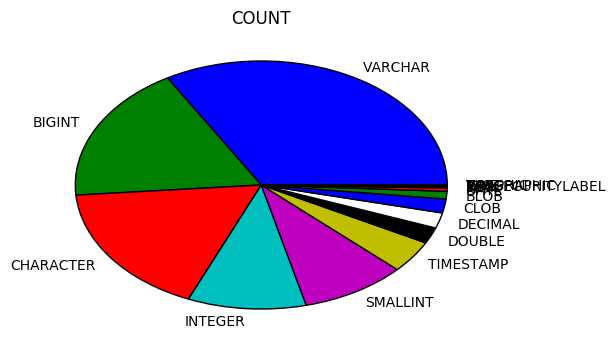

In [17]:
result= %sql select typename \
    , count(*) as count \
from syscat.columns \
group by typename \
order by count desc
%matplotlib inline
result.pie()

In [89]:
%sql WITH SUM_TAB (SUM_RR, SUM_CPU, SUM_EXEC, SUM_SORT, SUM_NUM_EXEC) AS ( \
        SELECT  nullif(FLOAT(SUM(ROWS_READ)),0), \
                nullif(FLOAT(SUM(TOTAL_CPU_TIME)),0), \
                nullif(FLOAT(SUM(STMT_EXEC_TIME)),0), \
                nullif(FLOAT(SUM(TOTAL_SECTION_SORT_TIME)),0), \
                nullif(FLOAT(SUM(NUM_EXECUTIONS)),0) \
            FROM TABLE(MON_GET_PKG_CACHE_STMT ( 'D', NULL, NULL, -2)) AS T \
        ) \
SELECT \
        ROWS_READ, \
        DECIMAL(100*(FLOAT(ROWS_READ)/SUM_TAB.SUM_RR),5,2) AS PCT_TOT_RR, \
        TOTAL_CPU_TIME, \
        DECIMAL(100*(FLOAT(TOTAL_CPU_TIME)/SUM_TAB.SUM_CPU),5,2) AS PCT_TOT_CPU, \
        STMT_EXEC_TIME, \
        DECIMAL(100*(FLOAT(STMT_EXEC_TIME)/SUM_TAB.SUM_EXEC),5,2) AS PCT_TOT_EXEC, \
        TOTAL_SECTION_SORT_TIME, \
        DECIMAL(100*(FLOAT(TOTAL_SECTION_SORT_TIME)/SUM_TAB.SUM_SORT),5,2) AS PCT_TOT_SRT, \
        NUM_EXECUTIONS, \
        DECIMAL(100*(FLOAT(NUM_EXECUTIONS)/SUM_TAB.SUM_NUM_EXEC),5,2) AS PCT_TOT_EXEC, \
        DECIMAL(FLOAT(STMT_EXEC_TIME)/FLOAT(NUM_EXECUTIONS),10,2) AS AVG_EXEC_TIME, \
        RTRIM(STMT_TEXT) as STATEMENT \
    FROM TABLE(MON_GET_PKG_CACHE_STMT ( 'D', NULL, NULL, -2)) AS T, SUM_TAB \
    WHERE DECIMAL(100*(FLOAT(ROWS_READ)/SUM_TAB.SUM_RR),5,2) > 10 \
        OR DECIMAL(100*(FLOAT(TOTAL_CPU_TIME)/SUM_TAB.SUM_CPU),5,2) >10 \
        OR DECIMAL(100*(FLOAT(STMT_EXEC_TIME)/SUM_TAB.SUM_EXEC),5,2) >10 \
        OR DECIMAL(100*(FLOAT(TOTAL_SECTION_SORT_TIME)/SUM_TAB.SUM_SORT),5,2) >10 \
        OR DECIMAL(100*(FLOAT(NUM_EXECUTIONS)/SUM_TAB.SUM_NUM_EXEC),5,2) >10 \
    ORDER BY ROWS_READ DESC FETCH FIRST 20 ROWS ONLY WITH UR

Done.


rows_read,pct_tot_rr,total_cpu_time,pct_tot_cpu,stmt_exec_time,pct_tot_exec,total_section_sort_time,pct_tot_srt,num_executions,pct_tot_exec_1,avg_exec_time,STATEMENT
64,37.20,0,0.00,5,9.61,0,None,16,14.67,0.31,SELECT TRIGNAME FROM SYSCAT.TRIGGERS WHERE TABNAME='POLICY' AND TABSCHEMA='SYSTOOLS'
50,29.06,0,0.00,1,1.92,0,None,10,9.17,0.10,"SELECT COLNAME, TYPENAME FROM SYSCAT.COLUMNS WHERE TABNAME='POLICY' AND TABSCHEMA='SYSTOOLS'"
40,23.25,0,0.00,2,3.84,0,None,5,4.58,0.40,"select tabschema , tabname , controlauth , deleteauth , insertauth , selectauth , updateauth from syscat.tabauth where grantee = ?"
16,9.30,0,0.00,13,25.00,0,None,16,14.67,0.81,SELECT POLICY FROM SYSTOOLS.POLICY WHERE MED='DB2CommonMED' AND DECISION='NOP' AND NAME='CommonPolicy'
2,1.16,15625,100.00,24,46.15,0,None,10,9.17,2.40,"CALL SYSPROC.SYSINSTALLOBJECTS('POLICY','V','','')"
0,0.00,0,0.00,0,0.00,0,None,48,44.03,0.00,SET CURRENT LOCK TIMEOUT 5
0,0.00,0,0.00,7,13.46,0,None,4,3.66,1.75,"WITH SUM_TAB (SUM_RR, SUM_CPU, SUM_EXEC, SUM_SORT, SUM_NUM_EXEC) AS ( SELECT nullif(FLOAT(SUM(ROWS_READ)),0), nullif(FLOAT(SUM(TOTAL_CPU_TIME)),0), nullif(FLOAT(SUM(STMT_EXEC_TIME)),0), nullif(FLOAT(SUM(TOTAL_SECTION_SORT_TIME)),0), nullif(FLOAT(SUM(NUM_EXECUTIONS)),0) FROM TABLE(MON_GET_PKG_CACHE_STMT ( 'D', NULL, NULL, -2)) AS T ) SELECT substr(stmt_text,1,25) as STATEMENT, ROWS_READ, coalesce(DECIMAL(100*(FLOAT(ROWS_READ)/SUM_TAB.SUM_RR),5,2),0) AS PCT_TOT_RR, TOTAL_CPU_TIME, coalesce(DECIMAL(100*(FLOAT(TOTAL_CPU_TIME)/SUM_TAB.SUM_CPU),5,2),0) AS PCT_TOT_CPU, STMT_EXEC_TIME, coalesce(DECIMAL(100*(FLOAT(STMT_EXEC_TIME)/SUM_TAB.SUM_EXEC),5,2),0) AS PCT_TOT_EXEC, TOTAL_SECTION_SORT_TIME, coalesce(DECIMAL(100*(FLOAT(TOTAL_SECTION_SORT_TIME)/SUM_TAB.SUM_SORT),5,2),0) AS PCT_TOT_SRT, NUM_EXECUTIONS, coalesce(DECIMAL(100*(FLOAT(NUM_EXECUTIONS)/SUM_TAB.SUM_NUM_EXEC),5,2),0) AS PCT_TOT_EXECS, DECIMAL(FLOAT(STMT_EXEC_TIME)/FLOAT(NUM_EXECUTIONS),10,2) AS AVG_EXEC_TIME, RTRIM(STMT_TEXT) as FULL_STATEMENT FROM TABLE(MON_GET_PKG_CACHE_STMT ( 'D', NULL, NULL, -2)) AS T, SUM_TAB WHERE DECIMAL(100*(FLOAT(ROWS_READ)/SUM_TAB.SUM_RR),5,2) > 10 OR DECIMAL(100*(FLOAT(TOTAL_CPU_TIME)/SUM_TAB.SUM_CPU),5,2) >10 OR DECIMAL(100*(FLOAT(STMT_EXEC_TIME)/SUM_TAB.SUM_EXEC),5,2) >10 OR DECIMAL(100*(FLOAT(TOTAL_SECTION_SORT_TIME)/SUM_TAB.SUM_SORT),5,2) >10 OR DECIMAL(100*(FLOAT(NUM_EXECUTIONS)/SUM_TAB.SUM_NUM_EXEC),5,2) >10 ORDER BY ROWS_READ DESC FETCH FIRST 20 ROWS ONLY WITH UR"


In [85]:
result= %sql WITH SUM_TAB (SUM_RR, SUM_CPU, SUM_EXEC, SUM_SORT, SUM_NUM_EXEC) AS ( \
        SELECT  nullif(FLOAT(SUM(ROWS_READ)),0), \
                nullif(FLOAT(SUM(TOTAL_CPU_TIME)),0), \
                nullif(FLOAT(SUM(STMT_EXEC_TIME)),0), \
                nullif(FLOAT(SUM(TOTAL_SECTION_SORT_TIME)),0), \
                nullif(FLOAT(SUM(NUM_EXECUTIONS)),0) \
            FROM TABLE(MON_GET_PKG_CACHE_STMT ( 'D', NULL, NULL, -2)) AS T \
        ) \
SELECT substr(stmt_text,1,25) as STATEMENT, \
        ROWS_READ, \
        coalesce(DECIMAL(100*(FLOAT(ROWS_READ)/SUM_TAB.SUM_RR),5,2),0) AS PCT_TOT_RR, \
        TOTAL_CPU_TIME, \
        coalesce(DECIMAL(100*(FLOAT(TOTAL_CPU_TIME)/SUM_TAB.SUM_CPU),5,2),0) AS PCT_TOT_CPU, \
        STMT_EXEC_TIME, \
        coalesce(DECIMAL(100*(FLOAT(STMT_EXEC_TIME)/SUM_TAB.SUM_EXEC),5,2),0) AS PCT_TOT_EXEC, \
        TOTAL_SECTION_SORT_TIME, \
        coalesce(DECIMAL(100*(FLOAT(TOTAL_SECTION_SORT_TIME)/SUM_TAB.SUM_SORT),5,2),0) AS PCT_TOT_SRT, \
        NUM_EXECUTIONS, \
        coalesce(DECIMAL(100*(FLOAT(NUM_EXECUTIONS)/SUM_TAB.SUM_NUM_EXEC),5,2),0) AS PCT_TOT_EXECS, \
        DECIMAL(FLOAT(STMT_EXEC_TIME)/FLOAT(NUM_EXECUTIONS),10,2) AS AVG_EXEC_TIME, \
        RTRIM(STMT_TEXT) as FULL_STATEMENT \
    FROM TABLE(MON_GET_PKG_CACHE_STMT ( 'D', NULL, NULL, -2)) AS T, SUM_TAB \
    WHERE DECIMAL(100*(FLOAT(ROWS_READ)/SUM_TAB.SUM_RR),5,2) > 10 \
        OR DECIMAL(100*(FLOAT(TOTAL_CPU_TIME)/SUM_TAB.SUM_CPU),5,2) >10 \
        OR DECIMAL(100*(FLOAT(STMT_EXEC_TIME)/SUM_TAB.SUM_EXEC),5,2) >10 \
        OR DECIMAL(100*(FLOAT(TOTAL_SECTION_SORT_TIME)/SUM_TAB.SUM_SORT),5,2) >10 \
        OR DECIMAL(100*(FLOAT(NUM_EXECUTIONS)/SUM_TAB.SUM_NUM_EXEC),5,2) >10 \
    ORDER BY ROWS_READ DESC FETCH FIRST 20 ROWS ONLY WITH UR
%matplotlib inline
df=result.DataFrame()
df.describe()

Done.


,rows_read,total_cpu_time,stmt_exec_time,total_section_sort_time,num_executions
count,6.000000,6.000000,6.000000,6.0,6.000000
mean,28.666667,2604.166667,7.500000,0.0,17.500000
std,26.553091,6378.879538,9.354143,0.0,15.514509
min,0.000000,0.000000,0.000000,0.0,5.000000
25%,5.500000,0.000000,1.250000,0.0,10.000000
50%,28.000000,0.000000,3.500000,0.0,13.000000
75%,47.500000,0.000000,11.000000,0.0,16.000000
max,64.000000,15625.000000,24.000000,0.0,48.000000


Show number of rows and number of columns of the output

In [71]:
df.shape

(5, 13)

Show the names of all columns, in a comma separated list

In [72]:
df.columns

Index(['STATEMENT', 'rows_read', 'pct_tot_rr', 'total_cpu_time', 'pct_tot_cpu',
       'stmt_exec_time', 'pct_tot_exec', 'total_section_sort_time',
       'pct_tot_srt', 'num_executions', 'pct_tot_execs', 'avg_exec_time',
       'full_statement'],
      dtype='object')

Sort the output by a different column

In [86]:
# sort output by a different column
df.sort_values(by=['stmt_exec_time'], ascending=False)

,STATEMENT,rows_read,pct_tot_rr,total_cpu_time,pct_tot_cpu,stmt_exec_time,pct_tot_exec,total_section_sort_time,pct_tot_srt,num_executions,pct_tot_execs,avg_exec_time,full_statement
4,CALL SYSPROC.SYSINSTALLOB,2,1.16,15625,100.00,24,48.00,0,0.00,10,9.25,2.40,"CALL SYSPROC.SYSINSTALLOBJECTS('POLICY','V',''..."
3,SELECT POLICY FROM SYSTOO,16,9.30,0,0.00,13,26.00,0,0.00,16,14.81,0.81,SELECT POLICY FROM SYSTOOLS.POLICY WHERE MED='...
0,SELECT TRIGNAME FROM SYS,64,37.20,0,0.00,5,10.00,0,0.00,16,14.81,0.31,SELECT TRIGNAME FROM SYSCAT.TRIGGERS WHERE TA...
2,"select tabschema , ta",40,23.25,0,0.00,2,4.00,0,0.00,5,4.62,0.40,"select tabschema , tabname , controlau..."
1,"SELECT COLNAME, TYPENAME",50,29.06,0,0.00,1,2.00,0,0.00,10,9.25,0.10,"SELECT COLNAME, TYPENAME FROM SYSCAT.COLUMNS ..."
5,SET CURRENT LOCK TIMEOUT,0,0.00,0,0.00,0,0.00,0,0.00,48,44.44,0.00,SET CURRENT LOCK TIMEOUT 5


Some data types may not be what is expected

In [74]:
df.dtypes

STATEMENT                  object
rows_read                   int64
pct_tot_rr                 object
total_cpu_time              int64
pct_tot_cpu                object
stmt_exec_time              int64
pct_tot_exec               object
total_section_sort_time     int64
pct_tot_srt                object
num_executions              int64
pct_tot_execs              object
avg_exec_time              object
full_statement             object
dtype: object

Convert incorrect columns to FLOAT

In [75]:
df[['pct_tot_rr']]=df[['pct_tot_rr']].astype(float)
df[['pct_tot_cpu']]=df[['pct_tot_cpu']].astype(float)
df[['pct_tot_exec']]=df[['pct_tot_exec']].astype(float)
df[['pct_tot_srt']]=df[['pct_tot_srt']].astype(float)
df[['pct_tot_execs']]=df[['pct_tot_execs']].astype(float)
df[['avg_exec_time']]=df[['avg_exec_time']].astype(float)

Verify the data type conversion worked

In [76]:
df.dtypes

STATEMENT                   object
rows_read                    int64
pct_tot_rr                 float64
total_cpu_time               int64
pct_tot_cpu                float64
stmt_exec_time               int64
pct_tot_exec               float64
total_section_sort_time      int64
pct_tot_srt                float64
num_executions               int64
pct_tot_execs              float64
avg_exec_time              float64
full_statement              object
dtype: object

Plot the data on multiple dimensions

<function matplotlib.pyplot.show>

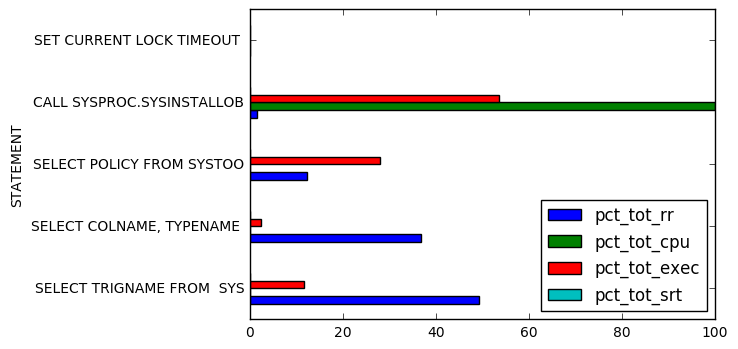

In [77]:
df.plot(x='STATEMENT', y=['pct_tot_rr','pct_tot_cpu','pct_tot_exec','pct_tot_srt'], kind='barh')
plt.show

In [90]:
pd.set_option('display.max_colwidth', -1)
df[['full_statement']]

,full_statement
0,SELECT TRIGNAME FROM SYSCAT.TRIGGERS WHERE TABNAME='POLICY' AND TABSCHEMA='SYSTOOLS'
1,"SELECT COLNAME, TYPENAME FROM SYSCAT.COLUMNS WHERE TABNAME='POLICY' AND TABSCHEMA='SYSTOOLS'"
2,"select tabschema , tabname , controlauth , deleteauth , insertauth , selectauth , updateauth from syscat.tabauth where grantee = ?"
3,SELECT POLICY FROM SYSTOOLS.POLICY WHERE MED='DB2CommonMED' AND DECISION='NOP' AND NAME='CommonPolicy'
4,"CALL SYSPROC.SYSINSTALLOBJECTS('POLICY','V','','')"
5,SET CURRENT LOCK TIMEOUT 5


### Using Host Variables / Parameter Markers

In [84]:
check_id = 'ECROOKS'
%sql select tabschema \
    , tabname \
    , controlauth \
    , deleteauth \
    , insertauth \
    , selectauth \
    , updateauth \
from syscat.tabauth \
where grantee = :check_id

Done.


tabschema,tabname,controlauth,deleteauth,insertauth,selectauth,updateauth
SYSTOOLS,STMG_DBSIZE_INFO,Y,G,G,G,G
ECROOKS,T1,Y,G,G,G,G
ECROOKS,CONTROL_ACT_STMT,Y,G,G,G,G
ECROOKS,ACTIVITY_ACT_STMT,Y,G,G,G,G
ECROOKS,ACTIVITYSTMT_ACT_STMT,Y,G,G,G,G
ECROOKS,ACTIVITYVALS_ACT_STMT,Y,G,G,G,G
ECROOKS,ACTIVITYMETRICS_ACT_STMT,Y,G,G,G,G
ECROOKS,T2,Y,G,G,G,G


### Explain Information in Jupyter Notebook

#### If Explain Tables do not Exist, Create Them

In [ ]:
# This cell only needs to be executed if the explain tables do not exist
%sql call sysproc.sysinstallobjects('EXPLAIN','C',NULL,NULL)

In [91]:
%sql set current explain mode explain
# Below will return CLI0115E, but that is expected and it works fine.
%sql select bpname from syscat.bufferpools

Done.
Done.


InternalError: (ibm_db_dbi.InternalError) ibm_db_dbi::InternalError: Fetch Failure: [IBM][CLI Driver] CLI0115E  Invalid cursor state. SQLSTATE=24000 SQLCODE=-99999

In [92]:
%sql set current explain mode no

Done.


[]

In [93]:
!db2exfmt -d SAMPLE -1 -o query_exfmt.txt

Connecting to the Database.


DB2 Universal Database Version 11.1, 5622-044 (c) Copyright IBM Corp. 1991, 2015
Licensed Material - Program Property of IBM
IBM DATABASE 2 Explain Table Format Tool

Connect to Database Successful.
Using SYSTOOLS schema for Explain tables.
Output is in query_exfmt.txt.
Executing Connect Reset -- Connect Reset was Successful.


In [94]:
with open("query_exfmt.txt") as f:
    for line in f:
        if line.rstrip() == "Access Plan:":
            print("")
            for line in f:
                if line.rstrip() == "Extended Diagnostic Information:":
                    break
                print(line.rstrip())


-----------
	Total Cost: 		0.00922488
	Query Degree:		1


       Rows
      RETURN
      (   1)
       Cost
        I/O
        |
         2
      IXSCAN
      (   2)
    0.00922488
         0
        |
         2
  INDEX: SYSIBM
 INDBUFFERPOOLS01
        Q1



